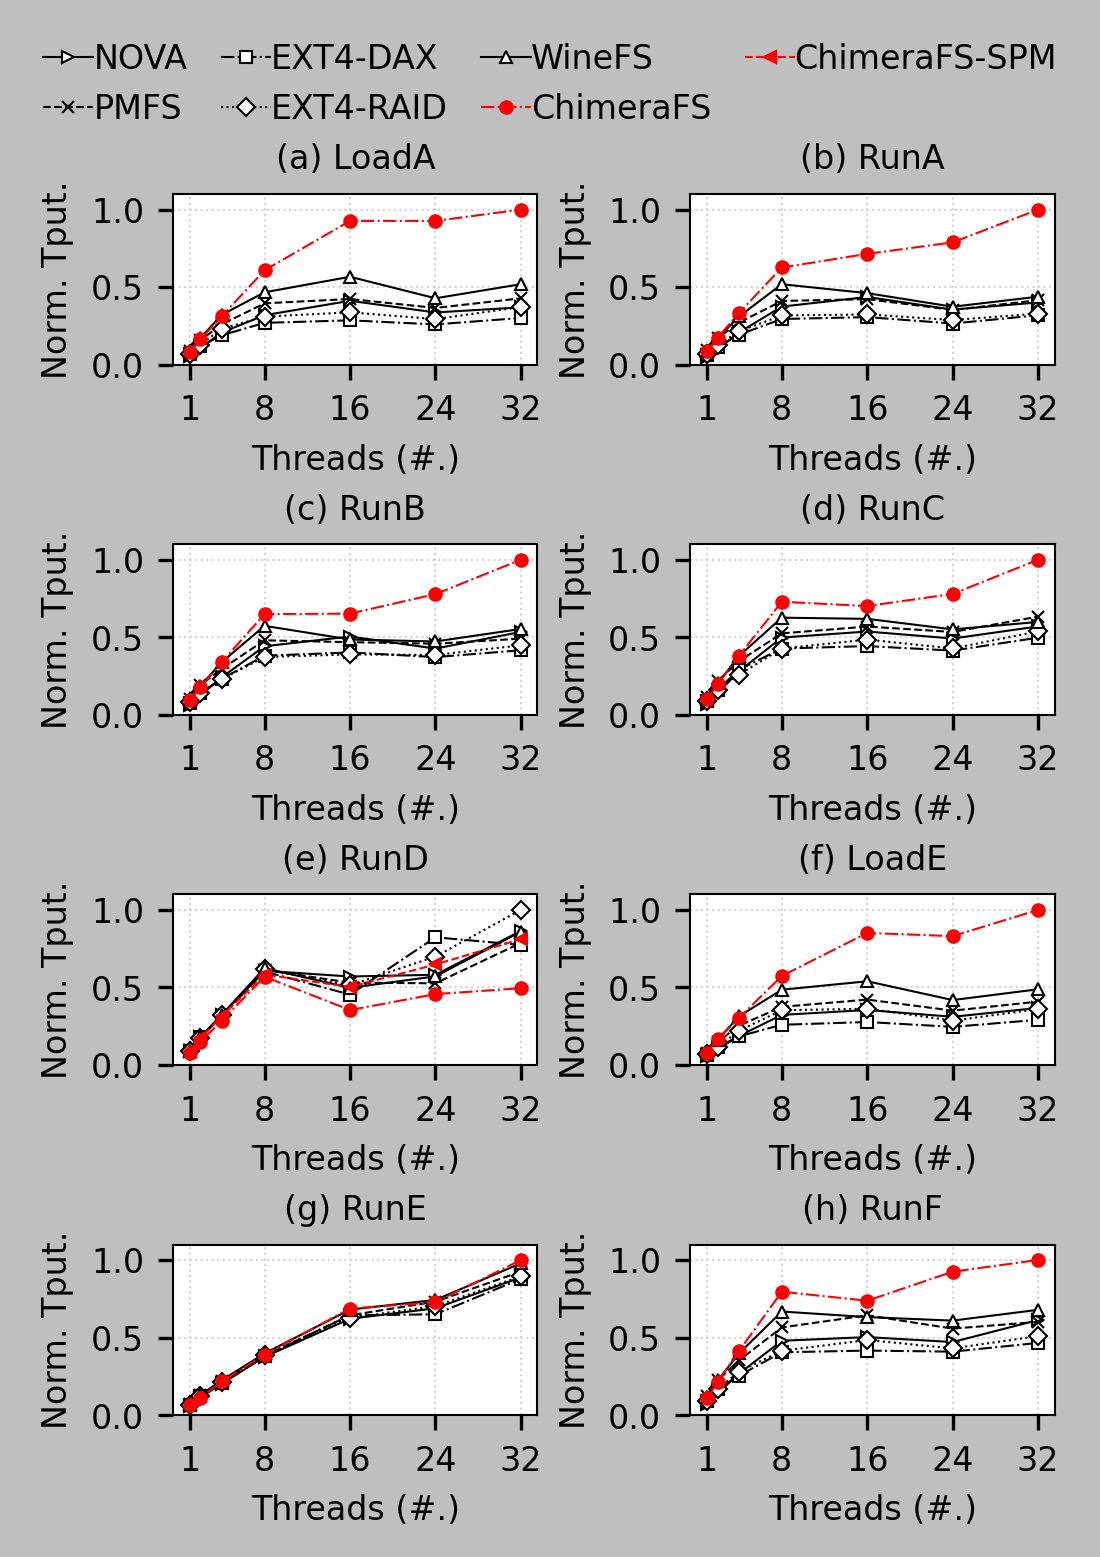

In [ ]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH

def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, index_col=None, engine='python', sep=' ')

# 调整画布尺寸为4x2布局（更瘦高的比例）
fig = plt.figure(dpi=300, figsize=(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(12)))  # 增加高度

colors = ['white', 'white', 'white', 'white', 'white', 'red', 'black']
marks = [">", "x", "s", "D", "^", "<", "o"]
line_patterns = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
workloads = ["loada(micros/op)", "runa(micros/op)", "runb(micros/op)", "runc(micros/op)",
             "rund(micros/op)", "loade(micros/op)", "rune(micros/op)", "runf(micros/op)"]
workloads_name_remap = ["(a) LoadA", "(b) RunA", "(c) RunB", "(d) RunC", "(e) RunD", "(f) LoadE", "(g) RunE", "(h) RunF"]
fss = ["nova", "pmfs", "ext4-dax", "ext4-raid", "winefs", "parfs-single-pm-12", "parfs-12"]
num_jobs = [1, 2, 4, 8, 16, 24, 32]
x = list(num_jobs)

mapping = {
    "nova": "NOVA",
    "pmfs": "PMFS",
    "ext4-dax": "EXT4-DAX",
    "ext4-raid": "EXT4-RAID",
    "winefs": "WineFS",
    "parfs-single-pm-12": "ChimeraFS-SPM",
    "parfs-12": "ChimeraFS",
}
mapped_fss = [mapping.get(item, item) for item in fss]

# 性能计算保持不变
for workload in workloads:
    for fs in fss:
        mask = df['fs'] == fs
        indices = df[mask].index[:len(num_jobs)]
        for i, idx in enumerate(indices):
            n = num_jobs[i]
            time_us = df.at[idx, workload]
            df.at[idx, workload] = (n * 1e6) / time_us
    max_tput = df[workload].max()
    df[workload] = df[workload] / max_tput

lines = []
for i in range(len(workloads)):
    ax = plt.subplot(4, 2, i+1)  # 4行2列布局
    workload = workloads[i]
    
    plt.title(workloads_name_remap[i], fontsize=8)
    
    # 绘制数据系列
    for idx, fs in enumerate(fss):
        if fs == "parfs-single-pm-12" and i != 4:
            continue
        y = df[(df['fs'] == fs)][workload].iloc[:len(num_jobs)]
        color="red" if fs == "parfs-12" or fs == "parfs-single-pm-12" else "black"
        markerfacecolor="red" if fs == "parfs-12" or fs == "parfs-single-pm-12" else colors[idx]
        markeregdecolor="red" if fs == "parfs-12" or fs == "parfs-single-pm-12" else "black"
        if fs == "parfs-single-pm-12":
            p, = plt.plot(x, y, color=color, markerfacecolor=markerfacecolor, 
                     linewidth=0.5, label=fs, marker=marks[idx],
                     markeredgecolor=markeregdecolor, markersize=3, markeredgewidth=0.5, linestyle=line_patterns[idx], zorder=10)
        else:
            p, = plt.plot(x, y, color=color, markerfacecolor=markerfacecolor, 
                     linewidth=0.5, label=fs, marker=marks[idx],
                     markeredgecolor=markeregdecolor, markersize=3, markeredgewidth=0.5, linestyle=line_patterns[idx])
        if i == 0 or (i == 4 and fs == "parfs-single-pm-12"):
            lines.append(p)
        # if i == 0:
        #     lines.append(p)

    # 坐标轴设置（所有子图显示完整坐标）
    plt.ylabel('Norm. Tput.', fontsize=8)  # 缩小标签字号
    plt.xlabel("Threads (#.)", fontsize=8)
    
    # 统一刻度设置
    ytick = [0, 0.5, 1]
    plt.yticks(ytick, fontsize=8)  # 精简Y轴刻度
    plt.xticks([1, 8, 16, 24, 32], [1, 8, 16, 24, 32], fontsize=8)  # 旋转X轴标签
    
    plt.ylim(0, 1.1)
    
    # plt.tick_params(left=True, bottom=True, right=False, top=False, which='major', width=0.5, length=3)
    # 设置边框线宽
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

# 调整图例位置和样式

mapped_fss_ordered = [mapping[fs] for fs in fss if fs != "parfs-single-pm-12"] + ["ChimeraFS-SPM"]

fig.legend(lines, mapped_fss_ordered, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4, columnspacing=1, handletextpad=0, handlelength=1.5, frameon=False, fontsize=8)

# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.6, wspace=0.3)
plt.tight_layout(pad=0.4)

plt.savefig("./Leveldb.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
import pandas as pd

# Load the new performance comparison data
# Assume the file is named 'performance-comparison-table-store' and is space-separated with a header line
df = pd.read_csv('performance-comparison-table', sep=r"\s+", header=0)

# Identify all metric columns (exclude 'fs' and 'num_job')
all_cols = list(df.columns)
metric_cols = [c for c in all_cols if c not in ['fs', 'num_job']]

# Exclude the 'rund' metric from analysis by filtering out any column name that starts with 'rund'
metric_cols = [c for c in metric_cols if not c.lower().startswith('rund')]

# Convert microseconds per operation to operations per second: ops_per_sec = 1e6 / (micros/op)
for col in metric_cols:
    df[f'perf_{col}'] = 1e6 / df[col]

# Pivot performance data so that fs types are columns for each metric
perf_dfs = {
    col: df.pivot(index='num_job', columns='fs', values=f'perf_{col}')
    for col in metric_cols
}

# Compute ratio DataFrames: parfs-12 performance divided by other fs performance
# Exclude 'parfs-single-pm-12' from comparison
ratio_dfs = {}
for metric, perf in perf_dfs.items():
    if 'parfs-12' not in perf.columns:
        raise ValueError(f"parfs-12 data not found for metric {metric}")
    # Drop parfs-single-pm-12 and parfs-12 from the list of other filesystems
    others = perf.columns.drop(['parfs-12', 'parfs-single-pm-12'], errors='ignore')
    # Compute parfs-12 / other filesystem performance
    ratio_df = pd.DataFrame(
        {fs: perf.loc[32, 'parfs-12'] / perf.loc[32, fs] for fs in others},
        index=[32]
    )
    ratio_dfs[metric] = ratio_df

# Collect highest and lowest ratios for each metric at 32 threads
results = []
for metric, ratio_df in ratio_dfs.items():
    row = ratio_df.loc[32]
    highest_fs = row.idxmax()
    highest_ratio = row.max()
    lowest_fs = row.idxmin()
    lowest_ratio = row.min()
    results.append({
        'metric': metric,
        'highest_fs': highest_fs,
        'highest_ratio': highest_ratio,
        'lowest_fs': lowest_fs,
        'lowest_ratio': lowest_ratio
    })

# Display results
results_df = pd.DataFrame(results)
print("Parfs-12 vs Others Ratios at 32 Threads (highest and lowest) per workload, excluding 'parfs-single-pm-12':")
print(results_df.to_string(index=False))


Parfs-12 vs Others Ratios at 32 Threads (highest and lowest) per workload, excluding 'parfs-single-pm-12':
          metric highest_fs  highest_ratio lowest_fs  lowest_ratio
loada(micros/op)   ext4-dax       3.320431    winefs      1.927691
 runa(micros/op)   ext4-dax       3.141660    winefs      2.280991
 runb(micros/op)   ext4-dax       2.402213    winefs      1.806664
 runc(micros/op)   ext4-dax       2.010397      pmfs      1.579265
loade(micros/op)   ext4-dax       3.431889    winefs      2.048344
 rune(micros/op)   ext4-dax       1.138572    winefs      1.021175
 runf(micros/op)   ext4-dax       2.146907    winefs      1.472368
